In [25]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import sys
from itertools import combinations 
import time
from scipy import stats
from sklearn.svm import SVC 
from shapely import geometry

In [26]:
#load data
raw_data = np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8,9))
raw_data_copy=np.copy(raw_data)

In [10]:
#array of unique edge grains for doubling
edge_grains=np.unique(raw_data[np.where(raw_data[:,6]==1),5])

In [11]:
#everything to calculate disorientations
a=sqrt(0.75)

#12 hexagonal close-packed crystal symmetry operators
op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
op29=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36

#list of hexagonal sym ops
hex_sym_ops=[op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36]

#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
#     #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #disorientation matrix
    #problem here!!!
#     delta_gd=np.matmul((np.matmul(g_two,sym_op)),(np.matmul(np.linalg.inv(sym_op),np.linalg.inv(g_one))))
    #formula from powerpoint
    delta_gd=np.matmul(sym_op,delta_g)
    
#     #angle in radians
#     theta=np.arccos((np.trace(delta_gd)-1)/2)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)


#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two,sym_ops):
    misorientation_list=[]
    for sym_op in sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
    
    #disorientation is the minimum of the 24 misorientations - for cubic symmetry 
    return min(misorientation_list)
#     return misorientation_list

In [12]:
#get area of each voronoi region
def voronoi_volumes(points):
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #ignore infinite regions
            vol[i] = 0
            
        else: #can compute area, use convex hull
            vert=v.vertices[indices]
            vert[np.where(vert<0)]=0
            vert[np.where(vert>110)]=110
            vol[i] = ConvexHull(vert).volume
                      
#             edge=0
#             small=np.where(vert<0)
#             large=np.where(vert>110)
#             if ((len(small[0])) > 0 or (len(large[0])) > 0):
#                 edge=1
#                 vert[small]=0
#                 vert[large]=110            
#             if edge==1: #double size of edge grains
#                 vol[i] = (2*ConvexHull(vert).volume)
#             else: #all vertices are inside 
#                 vol[i] = ConvexHull(vert).volume
                
    #can use grain IDs, since areas match input point
    return vol

In [13]:
def new_vor_p(num_bins=25,hist=True,mean_var=False):
    #slice array
    coords=raw_data[:,3:5] 
    grain_IDs=raw_data[:,5]
    grain_IDs_and_edges=raw_data[:,5:7]
    edge_grains=grain_IDs_and_edges[np.where(grain_IDs_and_edges[:,1]==1)]
    coords_and_grains=raw_data[:,3:6]
    coords_and_grains_copy=np.copy(coords_and_grains)

    #get areas
    vol=voronoi_volumes(coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
    
#     plt.title('100% of Data')
#     plt.xlabel('Grain Size')
#     plt.ylabel('Frequency')
#     plt.xlim(0,50)
#     plt.ylim(0,0.15)
#     plt.hist(count, bins=num_bins, range=(0,50), density=True)
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    
    if hist==True:
        return q
    
    if mean_var==True:
        total_mean=np.mean(count)
#         var=np.var(count)
        return total_mean

In [14]:
k3=new_vor_p(25)

In [15]:
#use scipy's js divergence
def js_divergence_scipy(hist1,hist2):
    #square distance to find divergence, use log2
    return (distance.jensenshannon(hist1, hist2, base=2))**2

In [16]:
#point adj dict
def adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

In [17]:
#only (a,b) instead of (a,b) and (b,a)
def mod_adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            #remove to prevent duplicates
#             neigh[j].add(i)
    return neigh

In [18]:
#create a grain adj dict
def grain_adj_dict(array,misorient_angle=15):    
    #create point adj dict
    vor_adj=adj_dict(array)
    
    # create grain adj dict
    grain_neigh=defaultdict(set)
    
    #create grain adj dict
    for key in vor_adj:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in vor_adj[key]:
            euler_two=[array[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
            if vor_disorient > misorient_angle:    
                #add to adj grain dict
                grain_ID_one=array[key,5]
                grain_ID_two=array[value,5]
                grain_neigh[int(grain_ID_one)].add(int(grain_ID_two))
                grain_neigh[int(grain_ID_two)].add(int(grain_ID_one))
                
    return grain_neigh

In [112]:
#initialize a grain adj dict for the raw data
new_grain_adj_dict=grain_adj_dict(raw_data)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos


In [19]:
# testing and plotting functions
# print(new_grain_adj_dict)
# logic=(np.where((raw_data[:,5]==607) | (raw_data[:,5]==561) | (raw_data[:,5]==644) | (raw_data[:,5]==510) | (raw_data[:,5]==596)))

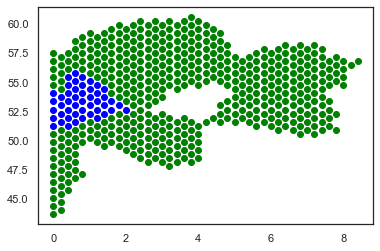

In [20]:
#load two grains for comparison
grain=raw_data[np.where(raw_data[:,5]==607)]
surrounding_grains=raw_data[np.isin(raw_data[:,5],[561,644,510,596])]
plt.scatter(grain[:,3],grain[:,4],color='blue',label='Cluster One')
plt.scatter(surrounding_grains[:,3],surrounding_grains[:,4],color='green',label='Cluster Two')

In [45]:
#create list of grain IDs to slice
IDs=[607,561,644,510,596]
#slice data for SVM
X=raw_data[(np.isin(raw_data[:,5],IDs)),3:5]
y=raw_data[(np.isin(raw_data[:,5],IDs)),5:6]
#modify y to be two clusters
y[np.where(y!=607)]=1
y[np.where(y==607)]=2
y=np.squeeze(y)

In [22]:
def plot_svc_decision_function(model, ax=None, number=30, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
#                levels=[-1, 0, 1], alpha=0.5,
#                linestyles=['--', '-', '--'])
               levels=[0], alpha=0.5,
               linestyles=['-'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


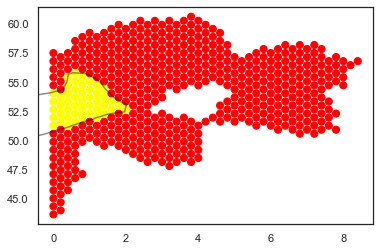

In [46]:
#create model
model = SVC(kernel='rbf', C=1e10, gamma=0.1)
model.fit(X, y)

#plot model
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

#return support vector
# model.support_vectors_

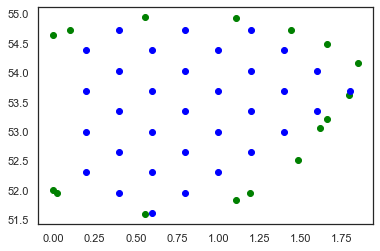

In [111]:
coords=raw_data[:,3:5]
in_polygon=np.zeros((len(coords),1))
coords=np.concatenate((coords,in_polygon.reshape(-1,1)),axis=1) #polygon_coords

#see how gaps affect the decision boundary
sample=50
random_slice=np.random.choice(X.shape[0], sample, replace=False)
random_X=X[random_slice, :]
random_y=y[random_slice]

#create model
model = SVC(kernel='rbf', C=1e10, gamma=1)
model.fit(random_X, random_y)

#plot model
plt.scatter(random_X[:, 0], random_X[:, 1], c=random_y, s=50, cmap='autumn')
polygon=svc_decision_boundary_length(model)

#plot decision boundary
plt.scatter(polygon[:,0],polygon[:,1], c='green')

#create polygon
polygon = np.vstack((polygon,polygon[0])) #close polygon
line = geometry.LineString(polygon)
polygon = geometry.Polygon(line)

#test if single points are in the polygon
index=0
for coord in coords:
    point = geometry.Point(coord)
    if polygon.contains(point):
        coords[index,2]=1
    index+=1

poly_coords=coords[np.where(coords[:,2]==1)]
plt.scatter(poly_coords[:,0],poly_coords[:,1], c='blue')

#adding unselected points, then draw boundary, then use same strategy with better support vectors

In [204]:
def nearest_neighbors(values, all_values, nbr_neighbors=1):
    nn = NearestNeighbors(nbr_neighbors, metric='euclidean', algorithm='kd_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return idxs

In [270]:
#improves previous method by including surrounding information and preventing errors when there are few support vectors
def SVM_infill(array):
    coords=raw_data[:,3:5] #need to change back to raw data, may change to improve runtime
    in_polygon=np.zeros((len(coords),4)) #expand to support orientations
    polygon_coords=np.concatenate((coords,in_polygon),axis=1) #.reshape(-1,1)
    
    #create grain adj dict
    new_grain_adj_dict=grain_adj_dict(array)
    #find SVM grain boundary using surrounding grains and expand to find support vectors
    for grain_ID in new_grain_adj_dict:
#     for grain_ID in [2]:
        #get the neighboring grain IDs
        IDs=list(new_grain_adj_dict[grain_ID])
        #append current ID
        IDs.append(grain_ID)

        #slice data for SVM
        X=array[(np.isin(array[:,5],IDs)),3:5]
        Y=array[(np.isin(array[:,5],IDs)),5:6]
        #modify Y to be two clusters
        Y[np.where(Y!=grain_ID)]=-1
        Y[np.where(Y==grain_ID)]=-2
        Y=np.squeeze(Y)
        
        #create model
        model = SVC(kernel='rbf', C=1e10, gamma=1)
        model.fit(X, Y)
        #plot model
#         plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
#         plot_svc_decision_function(model);

        #call model
        polygon=svc_decision_boundary_coords(model)
        #plot model
#         plt.scatter(polygon[:,0],polygon[:,1], c='green')
        
        #create polygon of model boundary
        polygon = np.vstack((polygon,polygon[0])) #close polygon
        line = geometry.LineString(polygon)
        polygon = geometry.Polygon(line)
        
        #test if single points are in the polygon
        index=0
        for coord in coords:
            point = geometry.Point(coord)
            if polygon.contains(point):
                #assign grain ID
                polygon_coords[index,2]=grain_ID
                #assign angles to nearest neighbor
                polygon_coords[index,3:6]=array[nearest_neighbors(coord.reshape(1,-1),array[:,3:5]),0:3]
            index+=1

        #plot results for a grain
#         poly_coords=polygon_coords[np.where(polygon_coords[:,2]==grain_ID)]
#         plt.scatter(poly_coords[:,0],poly_coords[:,1], c='blue')
       
   
    #assign gaps (zeros) to nearest point
    index=0
    for row in polygon_coords:
        if row[2]==0:
            polygon_coords[index,2]=raw_data[nearest_neighbors(polygon_coords[index,0:2].reshape(1,-1),array[:,3:5]),5]
        index+=1
#     return polygon_coords   
                                  
    #change grain IDs and angles to new ones
    infilled_raw_data=np.copy(raw_data)
    infilled_raw_data[:,0:3]=polygon_coords[:,3:6]
    infilled_raw_data[:,5]=polygon_coords[:,2]
                                  
    #use as input to grain_misorient calculation
    return infilled_raw_data

In [255]:
#window test data
xy_max=12
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]
#randomize
size=int(len(raw_data_slice)/4)
sliced_raw_data = raw_data_slice[np.random.choice(raw_data_slice.shape[0], size, replace=False), :]

In [271]:
infilled_raw_data = SVM_infill(raw_data)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos


KeyboardInterrupt: 

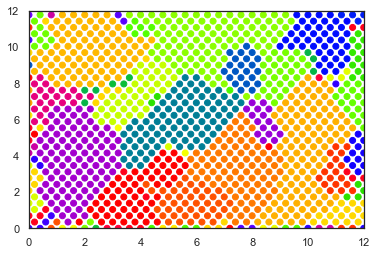

In [268]:
#plot polygon coords
plt.xlim(0,xy_max)
plt.ylim(0,xy_max)
plt.scatter(infilled_raw_data[:,3],infilled_raw_data[:,4],c=infilled_raw_data[:,5],cmap='prism') 

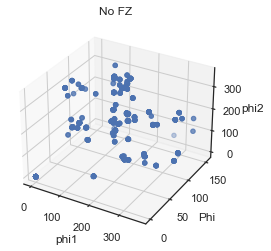

In [269]:
from mpl_toolkits import mplot3d

angles = np.degrees(infilled_raw_data[:,0:3])
phi1=angles[:,0]
Phi=angles[:,1]
phi2=angles[:,2]

#Without symmetry constraints
ax = plt.axes(projection='3d')
ax.set_title('No FZ')
ax.set_xlabel('phi1')
ax.set_ylabel('Phi')
ax.set_zlabel('phi2');
ax.scatter3D(phi1, Phi, phi2);

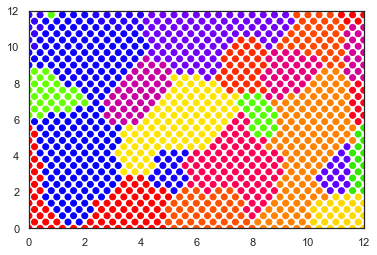

In [258]:
#actual coords
plt.xlim(0,xy_max)
plt.ylim(0,xy_max)
plt.scatter(raw_data_slice[:,3],raw_data_slice[:,4],c=raw_data_slice[:,5],cmap='prism') 

In [98]:
#returns the distribution of grain areas
def svm_grain_areas(array=raw_data, percent=100, random=False, grid=False, Window=False, mesh_res=30, C_=1e10,gam=1):
    #randomly sample
    if random == True:
        array=array[np.random.choice(array.shape[0], (int(len(array)*(percent/100))), replace=False)]

    sample_grain_adj_dict=grain_adj_dict(array)
    
    #array to hold the areas of each grain
    areas=np.zeros((len(np.unique(array[:,5])),1))
    grain_IDs=np.unique(array[:,5])
    grain_IDs_and_areas=np.concatenate((grain_IDs.reshape(-1,1),areas.reshape(-1,1)),axis=1)
    
    #calculate the area of each grain
    for grain_ID in sample_grain_adj_dict:
        #get the neighboring grain IDs
        IDs=list(new_grain_adj_dict[grain_ID])
        #append current ID
        IDs.append(grain_ID)

        #slice data for SVM
        X=array[(np.isin(array[:,5],IDs)),3:5]
        y=array[(np.isin(array[:,5],IDs)),5:6]
        #modify y to be two clusters
        y[np.where(y!=grain_ID)]=-1
        y[np.where(y==grain_ID)]=-2
        y=np.squeeze(y)
        
        try:
            #create model
            model = SVC(kernel='rbf', C=C_, gamma=gam)
            model.fit(X, y)
            #call model
            coords=svc_decision_boundary_length(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=mesh_res)

            #create polygon
            poly = geometry.Polygon(coords)
            #get area
            poly_area=poly.area
            
        except ValueError:
            #grain doesn't exist
            poly_area=0
            
        #append to array
        grain_IDs_and_areas[(np.where(grain_IDs_and_areas[:,0]==grain_ID)),1]=poly_area
        
    #double edge grains    
    row_ID=0
    for row in grain_IDs_and_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains):
            #double the total grain area
            grain_IDs_and_areas[row_ID,1]*=2
        row_ID+=1
    
    #return a probability vector (areas initially may not add up to one)
#     plt.hist(grain_IDs_and_areas[:,1], bins=25, range=(0,50), density=True)
    q_hist, q_bin_edges = np.histogram(grain_IDs_and_areas[:,1], bins=25, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

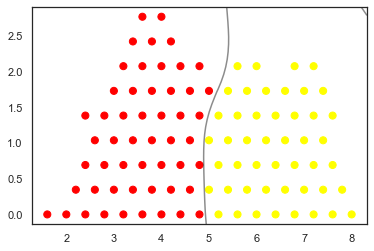

In [26]:
raw_data_slice=raw_data[np.where((raw_data[:,5]==2) | (raw_data[:,5]==3))]
X=raw_data_slice[:,3:5]
Y=raw_data_slice[:,5]

#create model
model = SVC(kernel='rbf', C=1e10, gamma=1)
model.fit(X, Y)

#plot model
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [28]:
def svc_decision_boundary_length(model,x_lim=(0,110),y_lim=(0,110),numb=200):
    """Return the decision boundary coordinates for a 2D SVC"""    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    
    boundary_coords = v[:,[0,1]]
    
#     return boundary_coords
    
    x = np.ravel(boundary_coords[:,0])
    y = np.ravel(boundary_coords[:,1])

    dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2
    return np.sum(np.sqrt(dist_array))

In [115]:
def svc_decision_boundary_coords(model,x_lim=(0,110),y_lim=(0,110),numb=200):
    """Return the decision boundary coordinates for a 2D SVC"""    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    
    boundary_coords = v[:,[0,1]]
    
    return boundary_coords

In [16]:
# #Plot coords
# model = SVC(kernel='rbf', C=1e10, gamma=1)
# model.fit(X, y)

# coords=svc_decision_boundary_length(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)
# plt.scatter(coords[:,0],coords[:,1])

# #create polygon
# poly = geometry.Polygon(coords)
# #get area
# poly_area=poly.area
# print(poly_area)

# #Return boundary length
# model = SVC(kernel='rbf', C=1e10, gamma=1)
# model.fit(X, y)

# boundary_len=svc_decision_boundary_length(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)
# print(boundary_len)

In [114]:
actual=svm_grain_areas(raw_data)

In [113]:
#initialize lists
random_percent=[]
random_divergence=[]

#calculate js divergence
for x in range (1,21,1):
    print(x)
    random_percent.append(x)
    random_divergence.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True)))

In [94]:
#add divergence at zero
random_percent.append(0)
random_divergence.append(1)

In [75]:
%store random_percent
%store random_divergence

Stored 'random_percent' (list)
Stored 'random_divergence' (list)


In [21]:
# %store random_percent_2
# %store random_divergence_2

Stored 'random_percent_2' (list)
Stored 'random_divergence_2' (list)


In [65]:
%store -d random_percent_2 
%store -d random_divergence_2 

In [68]:
%store -r

In [30]:
# #initialize lists
# grid_percent=[]
# for x in range(3,25,1):
#     grid_percent.append(((len(raw_data)/x)/len(raw_data))*100)

In [40]:
# #calculate js divergence
# grid_divergence=[]
# for x in range (3,25,1):j
#     print(x)
#     grid_array=raw_data[::x]
#     grid_divergence.append(js_divergence_scipy(actual,svm_grain_areas(grid_array)))

In [35]:
# #add divergence at zero (and one?)
# grid_percent.append(0)
# grid_divergence.append(1)

In [39]:
# %store grid_percent
# %store grid_divergence

Stored 'grid_percent' (list)
Stored 'grid_divergence' (list)


In [122]:
# # #initialize lists
# window_percent=[]
# window_divergence=[]

# #calculate js divergence
# for x in range (1,26,1):
#     print(x)
#     window_percent.append(x)
    
#     #create window array
#     percent=sqrt(x*100)
#     percent=percent/100
#     row_list=[]
#     for index in range(0,len(raw_data)):
#         if (raw_data[index,3]<=int((110*percent))) and (raw_data[index,4]<=int((110*percent))):
#             row_list.append(raw_data[index])
#         else:
#             continue
#     row_tuple=tuple(row_list)
#     window_array=np.vstack(row_tuple)
    
#     window_divergence.append(js_divergence_scipy(actual,svm_grain_areas(window_array)))

# #add divergence at zero
# window_percent.append(0)
# window_divergence.append(1)

# %store window_percent
# %store window_divergence

# x_min=np.amin(raw_data[:,3])
# x_max=np.amax(raw_data[:,3])
# y_min=np.amin(raw_data[:,4])
# y_max=np.amax(raw_data[:,4])
# #window one (bottom left)
# raw_data_slice_1 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] <= y_max/2))]

# # #window two (bottom right)
# raw_data_slice_2 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] <= y_max/2))]
# raw_data_slice_2[:,3] -= np.min(raw_data_slice_2[:,3])

# # #window three (top left)
# raw_data_slice_3 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] >= y_max/2))]
# raw_data_slice_3[:,4] -= np.min(raw_data_slice_3[:,4])

# # #window four (top right)
# raw_data_slice_4 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] >= y_max/2))]
# raw_data_slice_4[:,3] -= np.min(raw_data_slice_4[:,3])
# raw_data_slice_4[:,4] -= np.min(raw_data_slice_4[:,4])

# # #initialize lists
# window_percent_2=[]
# window_divergence_2=[]

# #calculate js divergence
# for x in range (1,26,1):
#     print(x)
#     window_percent_2.append(x)
    
#     #create window array
#     percent=sqrt(x*100)
#     percent=percent/100
#     row_list=[]
#     raw_data=raw_data_slice_2
#     for index in range(0,len(raw_data)):
#         if (raw_data[index,3]<=int((110*percent))) and (raw_data[index,4]<=int((110*percent))):
#             row_list.append(raw_data[index])
#         else:
#             continue
#     row_tuple=tuple(row_list)
#     window_array=np.vstack(row_tuple)
    
#     window_divergence_2.append(js_divergence_scipy(actual,svm_grain_areas(window_array)))
    
# #add divergence at zero
# window_percent_2.append(0)
# window_divergence_2.append(1)

# %store window_percent_2
# %store window_divergence_2

# # #initialize lists
# window_percent_3=[]
# window_divergence_3=[]

# #calculate js divergence
# for x in range (1,26,1):
#     print(x)
#     window_percent_3.append(x)
    
#     #create window array
#     percent=sqrt(x*100)
#     percent=percent/100
#     row_list=[]
#     raw_data=raw_data_slice_3
#     for index in range(0,len(raw_data)):
#         if (raw_data[index,3]<=int((110*percent))) and (raw_data[index,4]<=int((110*percent))):
#             row_list.append(raw_data[index])
#         else:
#             continue
#     row_tuple=tuple(row_list)
#     window_array=np.vstack(row_tuple)
    
#     window_divergence_3.append(js_divergence_scipy(actual,svm_grain_areas(window_array)))
    
# #add divergence at zero
# window_percent_3.append(0)
# window_divergence_3.append(1)

# %store window_percent_3
# %store window_divergence_3

# # #initialize lists
# window_percent_4=[]
# window_divergence_4=[]

# #calculate js divergence
# for x in range (1,26,1):
#     print(x)
#     window_percent_4.append(x)
    
#     #create window array
#     percent=sqrt(x*100)
#     percent=percent/100
#     row_list=[]
#     raw_data=raw_data_slice_4
#     for index in range(0,len(raw_data)):
#         if (raw_data[index,3]<=int((110*percent))) and (raw_data[index,4]<=int((110*percent))):
#             row_list.append(raw_data[index])
#         else:
#             continue
#     row_tuple=tuple(row_list)
#     window_array=np.vstack(row_tuple)
    
#     window_divergence_4.append(js_divergence_scipy(actual,svm_grain_areas(window_array)))
    
# #add divergence at zero
# window_percent_4.append(0)
# window_divergence_4.append(1)

# %store window_percent_4
# %store window_divergence_4

# window_array=np.array([np.array(window_divergence),np.array(window_divergence_2),np.array(window_divergence_3),np.array(window_divergence_4)])
# window_avg=(window_array.sum(axis=0))/4

# %store window_avg

# %store -r

# #increased resolution
# #initialize lists
# random_percent_2=[]
# random_divergence_2=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_2.append(x)
#     random_divergence_2.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=300)))

# #increased resolution
# #initialize lists
# random_percent_3=[]
# random_divergence_3=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_3.append(x)
#     random_divergence_3.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=30, gam=1)))

# #increased resolution
# #initialize lists
# random_percent_4=[]
# random_divergence_4=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_4.append(x)
#     random_divergence_4.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=30, gam=0.1)))

# #increased resolution
# #initialize lists
# random_percent_5=[]
# random_divergence_5=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_5.append(x)
#     random_divergence_5.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=30, gam=0.01)))

# #increased resolution
# #initialize lists
# random_percent_6=[]
# random_divergence_6=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_6.append(x)
#     random_divergence_6.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=30, gam=0.05)))

# %store random_divergence_6

# #increased resolution
# #initialize lists
# random_percent_7=[]
# random_divergence_7=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_7.append(x)
#     random_divergence_7.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=30, gam=1.5)))

# #decreased resolution
# #initialize lists
# random_percent_8=[]
# random_divergence_8=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_8.append(x)
#     random_divergence_8.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=3)))

In [ ]:
# #decreased resolution
# #initialize lists
# random_percent_8=[]
# random_divergence_8=[]

# #calculate js divergence
# for x in range (1,21,1):
#     print(x)
#     random_percent_8.append(x)
#     random_divergence_8.append(js_divergence_scipy(actual,svm_grain_areas(percent=x, random=True, mesh_res=3)))

In [134]:
# Voronoi P
#initialize lists
# random_percent_8=[]
random_divergence_9=[]

#calculate js divergence
for x in range (1,21,1):
#     print(x)
#     random_percent_8.append(x)
    random_divergence_9.append(js_divergence_scipy(k3,svm_grain_areas(percent=x, random=True, mesh_res=30)))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encount

In [114]:
%store random_divergence_7

Stored 'random_divergence_7' (list)


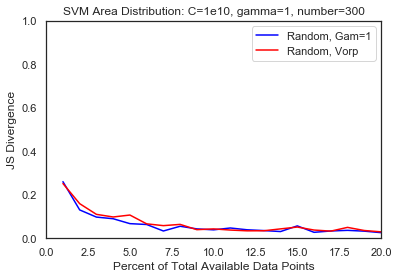

In [135]:
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('SVM Area Distribution: C=1e10, gamma=1, number=300')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Random
# sns.lineplot(random_percent, random_divergence, color="blue", label='Random, Res=30')
#Random
# sns.lineplot(random_percent_2, random_divergence_7, color="blue", alpha=0.2, label='Random, Gam=1.5')
#Random
sns.lineplot(random_percent_2, random_divergence_3, color="blue", alpha=1, label='Random, Gam=1')
#Random (Voronoi P)
sns.lineplot(random_percent_2, random_divergence_9, color="red", alpha=1, label='Random, Vorp')
# #Random
# sns.lineplot(random_percent_2, random_divergence_6, color="blue", alpha=0.8, label='Random, Gam=0.5')
# #Random
# sns.lineplot(random_percent_2, random_divergence_4, color="blue", alpha=0.6, label='Random, Gam=0.1')
# #Random
# sns.lineplot(random_percent_2, random_divergence_5, color="blue", alpha=0.4, label='Random, Gam=0.01')
# #Random (Increased Resolution)
# sns.lineplot(random_percent_2, random_divergence_2, color="gold", label='Random, Res=300')
# #Grid
# sns.lineplot(grid_percent, grid_divergence, color="red", label='Grid')
# # #Window 1
# # sns.lineplot(window_percent, window_divergence, color="gold", label='Window')
# # #Window 2
# # sns.lineplot(window_percent_2, window_divergence_2, color="gold", label='Window 2')
# # # #Window 3
# # sns.lineplot(window_percent_2, window_divergence_3, color="gold", label='Window')
# # # #Window 4
# # sns.lineplot(window_percent_2, window_divergence_4, color="gold", label='Window')
# # #Window Avg
# sns.lineplot(window_percent_2, window_avg, color="gold", label='Window')

In [110]:
%store random_divergence_3
%store random_divergence_4
%store random_divergence_5
%store
%store
%store

Stored 'random_divergence_3' (list)
Stored 'random_divergence_4' (list)
Stored 'random_divergence_5' (list)


In [27]:
# x=[1,2,3,4,5]
# y=[1,2,3,4,5]
# z=[[0,0,0],[1,0,0],(0,1,0),(0,0,1),(1,1,1)]
# z=np.array([[0.75300978, 0.85053038, 0.14082348],
#        [0.75300978, 0.85053038, 0.14082348],
#        [0.75300978, 0.85053038, 0.14082348],
#        [0.75300978, 0.85053038, 0.14082348],
#        [0.33091337, 0.62138864, 0.22023702]])
# plt.scatter(x,y,c=z)

# logic=np.where(raw_data[:,5]==1)
# raw_data=raw_data[logic]
# new_cmap=new_cmap[logic]

# print(np.amax(raw_data[:,0]))
# print(np.amax(raw_data[:,1]))
# print(np.amax(raw_data[:,2]))